# Work on the get_data function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
from tensorflow.keras.preprocessing.image import DirectoryIterator, ImageDataGenerator
from sklearn.model_selection import train_test_split

# Testing the LogisticRegression

In [6]:
def get_data(val_split = False, val_size = 0.3):
    '''Cette fonction parcourt le dossier contenant les images de départ et les renvoie,
    en uniformisant les tailles, sous forme de nd-arrays NumPy. La fonction exécute
    aussi un train_test_split qui distingue un dataset d'entraînement (70% des images)
    et un dataset de test (30% des images). '''
    path = '../catchafish/data'
    batch_size = 100000

    dir_iterator = DirectoryIterator(directory = path,
                                     image_data_generator = None,
                                     target_size = (32, 32),
                                     batch_size = batch_size,
                                     shuffle = False,
                                     dtype = int)

    X = dir_iterator[0][0]
    y = dir_iterator.labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

    if val_split:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size)
        return X_train, X_val, X_test, y_train, y_val, y_test
    else:
        return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = get_data()

Found 26385 images belonging to 10 classes.


In [8]:
def get_data_test():
    '''Cette  '''
    path = '../catchafish/data_test'
    batch_size = 1000

    dir_iterator = DirectoryIterator(directory = path,
                                     image_data_generator = None,
                                     target_size = (32, 32),
                                     batch_size = batch_size,
                                     shuffle = False,
                                     dtype = int)

    X_test = dir_iterator[0][0]
    y_test = dir_iterator.labels
    return X_test, y_test

In [9]:
X_test_last, y_test_last = get_data_test()

Found 253 images belonging to 10 classes.


In [34]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(n_jobs = -1, 
                            multi_class = 'multinomial', 
                            solver = 'lbfgs')

logreg.fit(X_train.reshape(18469, 32 * 32 * 3), y_train)

LogisticRegression(multi_class='multinomial', n_jobs=-1)

In [35]:
logreg.score(X_test.reshape(7916, 32 * 32 * 3), y_test)

0.9243304699343102

In [36]:
logreg.score(X_test_last.reshape(253, 32 * 32 * 3), y_test_last)

0.12648221343873517

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test_last, logreg.predict(X_test_last.reshape(253, 32 * 32 * 3))))

              precision    recall  f1-score   support

           0       0.07      0.14      0.10        21
           1       0.08      0.10      0.09        21
           2       0.00      0.00      0.00        20
           3       0.10      0.45      0.17        20
           4       0.22      0.16      0.19        25
           5       0.35      0.17      0.23        35
           6       0.00      0.00      0.00        34
           7       1.00      0.05      0.10        37
           8       0.40      0.10      0.16        20
           9       0.08      0.20      0.11        20

    accuracy                           0.13       253
   macro avg       0.23      0.14      0.11       253
weighted avg       0.28      0.13      0.12       253



# Transfer learning

## Usual steps

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from catchafish.data import get_data, get_data_test

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data_test(val_split = True)

Found 1305 images belonging to 11 classes.


/Users/Paul-Emmanuel/.pyenv/versions/3.7.7/envs/lewagon-data/lib/python3.7/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [10]:
# We make the necessary imports: as usual, the Sequential class and the layers module
# But we also introduce the VGG16 model, whose pre-trained parameters we will use for our own model
from tensorflow.keras import Sequential, layers
from tensorflow.keras.applications import VGG16

# We instantiate the sequential model
model = Sequential()

# And add the layers of the VGG16 while omitting the top ones 
model.add(VGG16(include_top = False, input_shape = (128, 128, 3)))

# At this stage, we want to keep the pre-trained parameters of the model
# So, we make the VGG16 layers non-trainable
for k, v in model._get_trainable_state().items():
    k.trainable = False

# We flatten the output of the VGG16
model.add(layers.Flatten())

# And add an intermediary dense layer with ReLU activation
model.add(layers.Dense(15, activation = 'relu'))

# Finally, the last layer will count 10 neurons and will have a softmax activation
# since we are talking a multiclass classification model
model.add(layers.Dense(11, activation = 'softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 15)                122895    
_________________________________________________________________
dense_5 (Dense)              (None, 11)                176       
Total params: 14,837,759
Trainable params: 123,071
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
# We can now compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [12]:
# And we can now train the model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 1)

model.fit(X_train, to_categorical(y_train), 
          validation_data = (X_val, to_categorical(y_val)),
          epochs = 1000, 
          batch_size = 32, 
          callbacks = [es], 
          verbose = 1)

Epoch 1/1000
100/100 [==============================] - 418s 4s/step - loss: 1.7860 - accuracy: 0.4250 - val_loss: 1.3397 - val_accuracy: 0.5788
Epoch 2/1000
100/100 [==============================] - 400s 4s/step - loss: 1.0373 - accuracy: 0.6879 - val_loss: 1.0869 - val_accuracy: 0.6474
Epoch 3/1000
100/100 [==============================] - 401s 4s/step - loss: 0.7560 - accuracy: 0.7837 - val_loss: 0.9704 - val_accuracy: 0.6737
Epoch 4/1000
100/100 [==============================] - 399s 4s/step - loss: 0.5795 - accuracy: 0.8388 - val_loss: 0.8688 - val_accuracy: 0.7153
Epoch 5/1000
100/100 [==============================] - 423s 4s/step - loss: 0.4569 - accuracy: 0.8836 - val_loss: 0.8366 - val_accuracy: 0.7292
Epoch 6/1000
100/100 [==============================] - 461s 5s/step - loss: 0.3530 - accuracy: 0.9224 - val_loss: 0.7834 - val_accuracy: 0.7365
Epoch 7/1000
100/100 [==============================] - 432s 4s/step - loss: 0.2835 - accuracy: 0.9455 - val_loss: 0.7943 - val_ac

KeyboardInterrupt: 

In [13]:
model.evaluate(X_test, to_categorical(y_test))

13/13 [==============================] - 32s 2s/step - loss: 0.7658 - accuracy: 0.7551


[0.7658067941665649, 0.7551020383834839]

In [15]:
predicted_probas = model.predict(X_test)
predicted_probas.shape

(392, 11)

In [19]:
y_pred = np.argmax(predicted_probas, axis = 1)

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.50      0.52        38
           1       0.76      0.60      0.67        42
           2       0.51      0.62      0.56        37
           3       0.88      0.85      0.87        34
           4       0.90      0.95      0.92        38
           5       0.68      0.89      0.77        36
           6       0.74      0.67      0.70        30
           7       0.85      0.83      0.84        42
           8       0.80      0.89      0.84        45
           9       0.85      0.82      0.84        28
          10       1.00      0.64      0.78        22

    accuracy                           0.76       392
   macro avg       0.77      0.75      0.76       392
weighted avg       0.76      0.76      0.75       392



## Digging into the results

In [21]:
bad_pred_idx = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]

In [36]:
wrong_predictions = y_test[bad_pred_idx]
wrong_predictions

array([ 8,  9,  7,  0,  0,  6,  4,  0,  0,  7,  2,  5,  3,  1, 10,  7,  0,
        6,  1,  8,  1,  0,  2,  0,  2,  0,  2,  1,  9,  7,  8,  8,  7,  1,
        1,  2,  2,  6,  2, 10,  5,  3,  6,  0,  9,  6,  5,  0,  7,  2,  0,
        2,  2,  0,  6, 10,  0, 10,  1,  0,  6,  1,  6,  1,  0,  2,  3,  0,
       10,  4,  1,  6, 10,  1,  0,  2,  1,  5,  3,  9,  2,  1,  3,  8,  7,
        1, 10,  2,  9,  0,  0,  6, 10,  1,  1,  1], dtype=int32)

In [31]:
first_class_predicted = []
second_class_predicted = []
third_class_predicted = []

for i in bad_pred_idx:
    
    first_class_predicted.append(np.argmax(predicted_probas[i]))
    
    row_probas = []
    for elt in predicted_probas[i]:
        if elt != max(predicted_probas[i]):
            row_probas.append(elt)
        else:
            row_probas.append(0)
    row_probas = np.array(row_probas)
        
    second_class_predicted.append(np.argmax(row_probas))
    
    row_probas_bis = []
    for elt in row_probas:
        if elt != max(row_probas):
            row_probas_bis.append(elt)
        else:
            row_probas_bis.append(0)
    row_probas_bis = np.array(row_probas_bis)
        
    third_class_predicted.append(np.argmax(row_probas))

In [39]:
secondary_predictions = np.array(second_class_predicted)
secondary_predictions

array([ 1,  9,  2,  7,  0,  6,  8,  0,  1,  2,  4,  1,  1,  1,  5,  1,  2,
        6,  1,  8,  2,  0,  2,  0,  2,  8,  2,  1,  6,  7,  8,  8,  2,  0,
        1,  2,  3,  1,  2, 10,  6,  3,  6,  1,  2,  5,  5,  0,  3,  1,  8,
        2,  5,  0,  1, 10,  6,  5,  1,  6,  6,  1,  8,  1,  1,  5,  1,  1,
        5,  6,  1,  6, 10,  5,  1,  5,  3,  1, 10,  9,  2,  5,  0,  8,  7,
        5, 10,  2,  8,  0,  6,  1,  3,  1,  0,  1])

In [40]:
from sklearn.metrics import accuracy_score

accuracy_score(wrong_predictions, secondary_predictions)

0.4583333333333333

In [41]:
secondary_bad_pred_idx = [i for i in range(len(wrong_predictions)) if wrong_predictions[i] != secondary_predictions[i]]

In [43]:
secondary_wrong_predictions = wrong_predictions[secondary_bad_pred_idx]
secondary_wrong_predictions

array([ 8,  7,  0,  4,  0,  7,  2,  5,  3, 10,  7,  0,  1,  0,  9,  7,  1,
        2,  6,  5,  0,  9,  6,  7,  2,  0,  2,  6,  0, 10,  0,  6,  0,  2,
        3,  0, 10,  4,  1,  0,  2,  1,  5,  3,  1,  3,  1,  9,  0,  6, 10,
        1], dtype=int32)

In [44]:
third_stage_predictions = np.array(third_class_predicted)[secondary_bad_pred_idx]
third_stage_predictions

array([ 1,  2,  7,  8,  1,  2,  4,  1,  1,  5,  1,  2,  2,  8,  6,  2,  0,
        3,  1,  6,  1,  2,  5,  3,  1,  8,  5,  1,  6,  5,  6,  8,  1,  5,
        1,  1,  5,  6,  5,  1,  5,  3,  1, 10,  5,  0,  5,  8,  6,  1,  3,
        0])

In [47]:
from sklearn.metrics import accuracy_score

accuracy_score(secondary_wrong_predictions, third_stage_predictions)

0.0

# Data augmentation

In [46]:
zca_whitening = False

In [47]:
path = '../catchafish/data_test'
batch_size = 1500

dir_iterator = DirectoryIterator(directory = path, 
                                 image_data_generator = None,
                                 target_size = (128, 128),
                                 batch_size = batch_size,
                                 shuffle = False,
                                 dtype = int)

X = dir_iterator[0][0] / 255
y = dir_iterator.labels

Found 1305 images belonging to 11 classes.


In [48]:
X.shape

(1305, 128, 128, 3)

In [49]:
y.shape

(1305,)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [51]:
image_data_generator = ImageDataGenerator(zca_whitening = zca_whitening, 
                                          rotation_range = 5,
                                          width_shift_range = 0.3, 
                                          height_shift_range = 0.3, 
                                          shear_range = 0.3, 
                                          zoom_range = 0.3, 
                                          horizontal_flip = True, 
                                          fill_mode = 'nearest')

In [52]:
if zca_whitening:
    image_data_generator.fit(X_train)

In [53]:
extended_output = []
for images in image_data_generator.flow(X_train, y_train, batch_size = batch_size):
    extended_output.append(images)
    if len(extended_output) == 5:
        break

In [54]:
X_train = extended_output[0][0]
y_train = extended_output[0][1]

In [55]:
for data_tuple in extended_output[1:]:
    X_train = np.concatenate((X_train, data_tuple[0]), axis = 0)
    y_train = np.concatenate((y_train, data_tuple[1]), axis = 0)

In [56]:
X_train.shape

(4565, 128, 128, 3)

In [57]:
y_train.shape

(4565,)

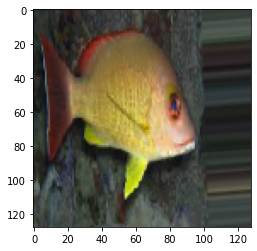

In [58]:
plt.imshow(X_train[3962])

In [59]:
y_train[3962]

9

In [61]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3]))

# New logistic regression

In [63]:
%%time
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(n_jobs = -1, multi_class = 'multinomial', solver = 'lbfgs')

logreg.fit(X_train_reshaped, y_train)

CPU times: user 1.35 s, sys: 2.8 s, total: 4.15 s
Wall time: 13min 47s


LogisticRegression(multi_class='multinomial', n_jobs=-1)

In [65]:
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2] * X_test.shape[3]))

In [66]:
logreg.score(X_test_reshaped, y_test)

0.24489795918367346

In [67]:
from sklearn.metrics import classification_report

print(classification_report(y_test, logreg.predict(X_test_reshaped)))

              precision    recall  f1-score   support

           0       0.25      0.32      0.28        38
           1       0.37      0.24      0.29        42
           2       0.23      0.22      0.22        37
           3       0.17      0.06      0.09        34
           4       0.33      0.53      0.40        38
           5       0.23      0.31      0.26        36
           6       0.11      0.13      0.12        30
           7       0.38      0.19      0.25        42
           8       0.11      0.09      0.10        45
           9       0.23      0.25      0.24        28
          10       0.26      0.45      0.33        22

    accuracy                           0.24       392
   macro avg       0.24      0.25      0.24       392
weighted avg       0.25      0.24      0.23       392



# Decision tree

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from catchafish.data import get_data, get_data_test

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data_test(val_split = True)

Found 1305 images belonging to 11 classes.


/Users/Paul-Emmanuel/.pyenv/versions/3.7.7/envs/lewagon-data/lib/python3.7/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [8]:
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (3195, 128, 128, 3)
Shape of X_val: (1370, 128, 128, 3)
Shape of X_test: (392, 128, 128, 3)


In [9]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3]))
X_val_reshaped = np.reshape(X_val, (X_val.shape[0], X_val.shape[1] * X_val.shape[2] * X_val.shape[3]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2] * X_test.shape[3]))

In [10]:
print('Shape of X_train_reshaped:', X_train_reshaped.shape)
print('Shape of X_val_reshaped:', X_val_reshaped.shape)
print('Shape of X_test_reshaped:', X_test_reshaped.shape)

Shape of X_train_reshaped: (3195, 49152)
Shape of X_val_reshaped: (1370, 49152)
Shape of X_test_reshaped: (392, 49152)


In [12]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_train_reshaped, y_train)

DecisionTreeClassifier()

In [13]:
decision_tree.score(X_val_reshaped, y_val)

0.1948905109489051

In [14]:
decision_tree.score(X_test_reshaped, y_test)

0.2372448979591837

# Random Forest

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
from catchafish.data import get_data, get_data_test

In [17]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data_test(val_split = True)

Found 1305 images belonging to 11 classes.


/Users/Paul-Emmanuel/.pyenv/versions/3.7.7/envs/lewagon-data/lib/python3.7/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [18]:
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (3195, 128, 128, 3)
Shape of X_val: (1370, 128, 128, 3)
Shape of X_test: (392, 128, 128, 3)


In [19]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3]))
X_val_reshaped = np.reshape(X_val, (X_val.shape[0], X_val.shape[1] * X_val.shape[2] * X_val.shape[3]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2] * X_test.shape[3]))

In [20]:
print('Shape of X_train_reshaped:', X_train_reshaped.shape)
print('Shape of X_val_reshaped:', X_val_reshaped.shape)
print('Shape of X_test_reshaped:', X_test_reshaped.shape)

Shape of X_train_reshaped: (3195, 49152)
Shape of X_val_reshaped: (1370, 49152)
Shape of X_test_reshaped: (392, 49152)


In [21]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

random_forest.fit(X_train_reshaped, y_train)

RandomForestClassifier()

In [22]:
random_forest.score(X_val_reshaped, y_val)

0.3781021897810219

In [23]:
random_forest.score(X_test_reshaped, y_test)

0.3852040816326531